In [1]:
import os
import pandas as pd
import pickle
from importlib import reload
import lime.lime_rdf
from rdflimeConfig import movieLocation
import logging 

logging.basicConfig(level=logging.WARN)

movieFull = pd.read_csv(os.path.join(movieLocation, "movies_fixed.tsv"), sep="\t")
movies = [movie.DBpedia_URI for _, movie in movieFull.iterrows()]

In [2]:
pcopy = lambda o: pickle.loads(pickle.dumps(o))

In [ ]:
for i in range(400):
    explained_entity_id = i  # 0-400 -> test data
    explained_entity_uri = movies[explained_entity_id]
    prediction = clf.predict_proba([rdf2vec_transformer._embeddings[explained_entity_id]])

    if(0.48 < prediction[0][0] < 0.52):
        print("Explaining", explained_entity_uri, i)
        print("Original prediction:", prediction, " / ".join(clf.classes_))
        print("True class:", movieFull.iloc[explained_entity_id].label)

In [4]:
reload(lime.lime_rdf)
from lime.lime_rdf import LimeRdfExplainer

with open(os.path.join(movieLocation, "transformers", "rdf2vec_transformer_cbow_200"), "rb") as file:
    rdf2vec_transformer = pickle.load(file)

with open(os.path.join(movieLocation, "classifiers", "svc_100_cbow_200"), "rb") as file:
    clf = pickle.load(file)

explainer = LimeRdfExplainer(
    transformer=rdf2vec_transformer, 
    entities=movies,
    class_names=clf.classes_,
    kernel=None,
    kernel_width=25,
    verbose=False,
    feature_selection="auto",
    random_state=42
)


explained_entity_id = 7  # 0-400 -> test data
explained_entity_uri = movies[explained_entity_id]
prediction = clf.predict_proba([rdf2vec_transformer._embeddings[explained_entity_id]])


print("Explaining", explained_entity_uri)
print("Original prediction:", prediction, " / ".join(clf.classes_))
print("True class:", movieFull.iloc[explained_entity_id].label)
 
"""
Grid search
ids = [1662, 1735, 1796, 1856, 1935]
max_removed_triples = [1, 10, 25, 100]
removal_count_fixed = [True, False]
use_w2v_freeze = [True, False]
center_correction = [True, False]
center_init = [True, False]
single_run = [True, False]
"""

data, probabilities, distances, explanation = explainer.explain_instance(
    entity=explained_entity_uri, 
    classifier_fn=clf.predict_proba,
    num_features=100,
    num_samples=3500,
    allow_triple_addition=True,
    allow_triple_substraction=True,
    max_changed_triples=5,
    change_count_fixed=True,
    use_w2v_freeze=True,
    center_correction=False,
    single_run=False,
    train_with_all=False,
    distance_metric="cosine",
    model_regressor=None,
    short_uris=False
)

Explaining http://dbpedia.org/resource/Star_Wars_(film)
Original prediction: [[0.03639992 0.96360008]] bad / good
True class: good
Preparing walks:


100%|██████████| 5000/5000 [00:44<00:00, 112.21it/s]


Average remaining walks per artificial entity (from 484): 483.6926
Training W2V with new corpus:


100%|██████████| 5000/5000 [09:30<00:00,  8.76it/s]


Got data, labels, and distances


: 

: 

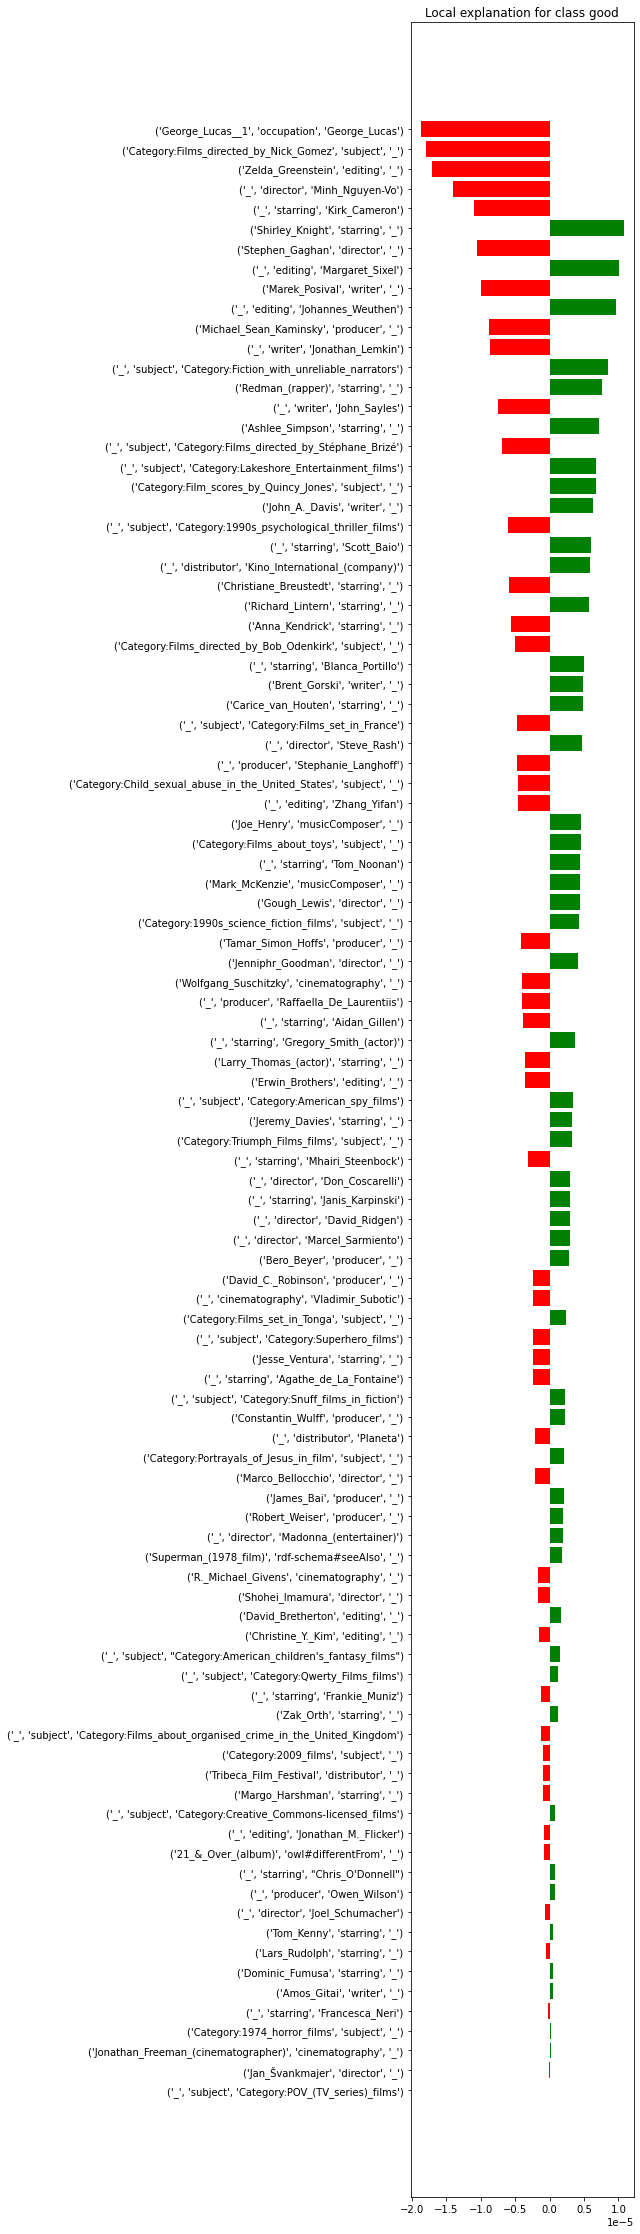

In [3]:
figsize = (4, .4*len(explanation.as_list()))

explanation.domain_mapper.short_uris=True
fig = explanation.as_pyplot_figure(figsize=figsize)
explanation.domain_mapper.short_uris=False


In [ ]:
movieFull[:400].head(20)

explanation.as_list()

<AxesSubplot:>

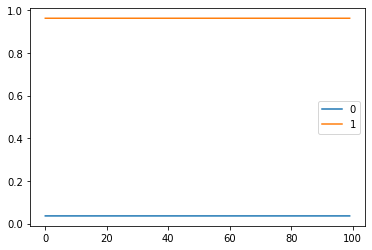

In [52]:
pd.DataFrame(labels).plot()

# thesis: show plot with/without single_run

In [30]:
iw = explainer.indexed_walks

top_triples = explanation.as_list()

relevant_walks = []
for triple in top_triples:
    for w in iw.walks(explained_entity_uri, tuple(triple[0])):
        
        entity_pos = w.index(explained_entity_uri)

        for i in range(2, len(w)):
            if w[i-2] == triple[0][0] and w[i-1] == triple[0][1] and w[i] == triple[0][2]:
                triple_start_pos = i-2
                triple_end_pos = i
        
        from_pos = min(entity_pos, triple_start_pos)
        to_pos = max(entity_pos, triple_end_pos)

        relevant_walks.append(w[from_pos:to_pos+1])



relevant_triples = iw.walks_as_triples(relevant_walks)

In [37]:
top_triples

[(('_',
   'http://dbpedia.org/ontology/musicComposer',
   'http://dbpedia.org/resource/Charlie_Clouser'),
  2.615797061204193e-05),
 (('http://dbpedia.org/resource/Jessica_Sanders_(director)',
   'http://dbpedia.org/ontology/producer',
   '_'),
  2.3380977389518925e-05),
 (('_',
   'http://dbpedia.org/ontology/writer',
   'http://dbpedia.org/resource/Francis_Veber'),
  -1.5891382175134937e-05),
 (('http://dbpedia.org/resource/Category:Films_directed_by_Vondie_Curtis-Hall',
   'http://purl.org/dc/terms/subject',
   '_'),
  -1.4806049075500794e-05),
 (('_',
   'http://dbpedia.org/ontology/starring',
   'http://dbpedia.org/resource/Madeline_Kahn'),
  -1.4075768114575273e-05),
 (('_',
   'http://dbpedia.org/ontology/producer',
   'http://dbpedia.org/resource/Todd_Phillips'),
  -1.3293068354959186e-05),
 (('_',
   'http://purl.org/dc/terms/subject',
   'http://dbpedia.org/resource/Category:American_teen_romance_films'),
  -1.256271185382124e-05),
 (('http://dbpedia.org/resource/Terence_Dav

In [31]:
edges = []
labels = {}

min_edge_width = 0.25
max_edge_width = 8
max_score = max([abs(exp[1]) for exp in top_triples])

uri_trimmer = lambda uri: uri.split("/")[-1].split("#")[-1].replace(":", "_")
triple_trimmer = lambda triple: (uri_trimmer(triple[0]), uri_trimmer(triple[1]), uri_trimmer(triple[2]))

for rt in relevant_triples:
    score = next((exp[1] for exp in top_triples if rt==exp[0]), None)
    
    if score:
        score *= -1
        color = "green" if score > 0 else "red"
        width = max(abs(score)/max_score*max_edge_width, min_edge_width)
    else:
        color = "blue"
        width = min_edge_width
        #print(rt, score)

    rt = triple_trimmer(rt)
    edge = (rt[0], rt[2], {"width": width, "color": color})
    
    label = rt[1]
    if score: label += f" ({round(width/max_edge_width, 2)})"

    edges.append(edge)
    
    labels[(edge[0],edge[1])] = label
    


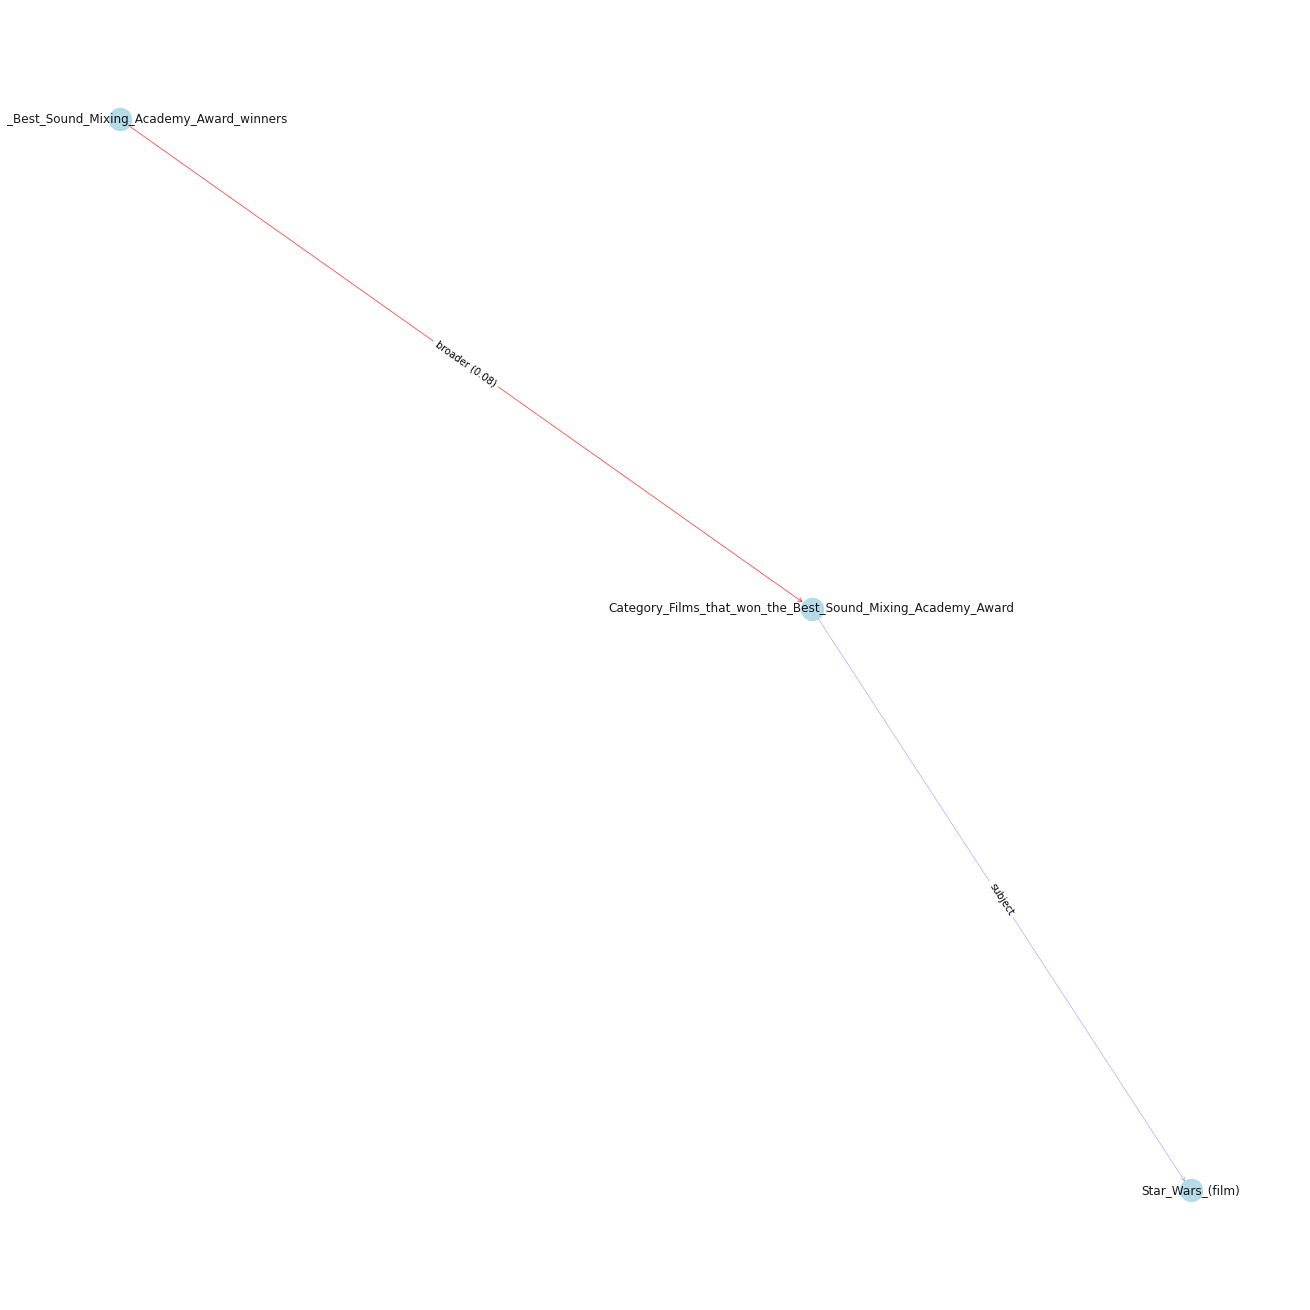

In [32]:
import matplotlib.pyplot as plt
import networkx as nx
from math import sqrt


G = nx.DiGraph()
G.add_edges_from(edges)
#pos = nx.spring_layout(G, k=1.25/sqrt(len(G.nodes())), seed=42, iterations=35)
pos = nx.nx_pydot.graphviz_layout(G, prog="neato")
plt.figure(figsize=(18,18))
nx.draw(
    G, pos,
    node_size=500, node_color='lightblue', alpha=0.9,
    labels={node: node for node in G.nodes()},
    arrowstyle='->',
    width=[G[u][v]['width'] for u,v in G.edges()],
    edge_color=[G[u][v]['color'] for u,v in G.edges()],
)


_ = nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels=labels,
    font_color='black',
)


nx.write_gexf(G, "test.gexf")

plt.savefig("green_lantern.pdf")

x = nx.nx_pydot.to_pydot(G)

# Bug: node labels with :

In [45]:
from pyvis.network import Network
nt = Network('500px', '500px')
nt.from_nx(G)
nt.show("nx.html")

In [ ]:
wv_old = explainer.old_transformer.embedder._model.wv
wv_new = explainer.transformer.embedder._model.wv
def embedding(URI, new):
    wv = wv_new if new else wv_old
    return wv.get_vector(URI)

In [ ]:
wv_old.most_similar(explainer.new_embeddings[150])

In [ ]:
# Check if the movie embedding itself drifted
all(embedding(explained_entity_uri, new=True) == embedding(explained_entity_uri, new=False))

In [ ]:
for walk in explainer.indexedWalks.walks(e):
    for step in walk:
        if not step in changed and not step == e:
            print(step)

In [ ]:
drifted = 0
changed = []

for i in range(len(wv_old)):
    if not (wv_old[i] == wv_new[i]).all():
        changed.append(wv_new.index_to_key[i])

        drifted += 1

print(drifted) 

In [ ]:
explainer.transformer.embedder._model.wv.most_similar(explainer.new_embeddings[0])

In [ ]:
len(explainer.old_transformer._embeddings + explainer.new_embeddings)

In [ ]:
movies

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
# Reduce the dimensions of entity embeddings to represent them in a 2D plane.
X_tsne = TSNE(random_state=42).fit_transform([wv_old[explained_entity_uri]] + explainer.new_embeddings)

labels = explainer.old_transformer._entities + list(range(len(explainer.new_embeddings)))
labels = [explained_entity_uri] + list(range(len(explainer.new_embeddings)))

#colors = list(map(lambda e: "#00ff00" if movieTest[movieTest.DBpedia_URI==e].iloc[0].label == "good" else "#ff0000", transformer._entities[1600:]))
#sizes = list(map(lambda e: abs(50-movieTest[movieTest.DBpedia_URI==e].iloc[0].rating)**2, transformer._entities[1600:]))
sizes = list(map(lambda l: 100**2 if l == explained_entity_uri or l == 0 else 25**2, labels))

# Ploy the embeddings of entities in a 2D plane, annotating them.
f = plt.figure(figsize=(200, 80))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=sizes)#, c=colors, s=sizes)

for x, y, t in zip(X_tsne[:, 0], X_tsne[:, 1], labels):
    if type(t) == str and "http" in t: t = t.split("/")[-1]
    plt.annotate(t, (x, y))

# Display the graph with a title, removing the axes for better readability.
plt.title("pyRDF2Vec", fontsize=4)
plt.axis("off")
plt.show()

#f.savefig("figure.pdf", bbox_inches='tight')


In [ ]:
import numpy as np



In [ ]:
with open("corpus.text", "wb") as f:
    pickle.dump(corpus, f)
    

### Experiments

In [ ]:
unique_triples = len(explainer.indexed_walks.walks_as_triples(explainer.indexed_walks.walks(explained_entity_uri)))
unique_triples

In [ ]:
keanu = embedding("http://dbpedia.org/resource/Keanu_Reeves", new=True)
matrix = embedding("http://dbpedia.org/resource/The_Matrix", new=True)
wv_new.most_similar(matrix-keanu, topn=len(wv_new))[0]
wv_new.most_similar(positive=["http://dbpedia.org/resource/The_Matrix"], negative=["http://dbpedia.org/resource/Keanu_Reeves"])

In [35]:
movie_search = lambda query: [(i,x) for i,x in enumerate(movies) if query.lower() in x.lower()]
movie_search("star")

[(7, 'http://dbpedia.org/resource/Star_Wars_(film)'),
 (106, 'http://dbpedia.org/resource/Star_Trek_II:_The_Wrath_of_Khan'),
 (145, 'http://dbpedia.org/resource/Star_Trek_IV:_The_Voyage_Home'),
 (496, 'http://dbpedia.org/resource/Position_Among_the_Stars'),
 (597, 'http://dbpedia.org/resource/Starting_Out_in_the_Evening'),
 (607, 'http://dbpedia.org/resource/Lone_Star_(1996_film)'),
 (671, 'http://dbpedia.org/resource/Startup.com'),
 (823, 'http://dbpedia.org/resource/Star_Trek:_First_Contact'),
 (1026, 'http://dbpedia.org/resource/Star_Trek_VI:_The_Undiscovered_Country'),
 (1068, 'http://dbpedia.org/resource/Star_Trek:_Insurrection'),
 (1375, 'http://dbpedia.org/resource/Dickie_Roberts:_Former_Child_Star'),
 (1399, 'http://dbpedia.org/resource/Stardom'),
 (1450, 'http://dbpedia.org/resource/Star_Wars:_The_Clone_Wars_(film)'),
 (1989, 'http://dbpedia.org/resource/Bucky_Larson:_Born_to_Be_a_Star')]

In [ ]:
movieFull[200:220]

In [ ]:
from concurrent.futures import ProcessPoolExecutor

def xm(i): 
    print(i)

with ProcessPoolExecutor() as executor:
    executor.map(xm, [1,2,3])